# Plotting MSE over (max) Sensitivity
Plot mean squared error over maximal sensitivity calculated 
via the given ratio type (i.e. sensitivity per timestep) and given
the trajectory to use for sensitivities (i.e. the original trajectory
from which model parameters have been perturbed) and for mean.

In [1]:
from glob import glob
from multiprocessing import Pool
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from progressbar import progressbar as pb
import xarray as xr
from scripts.Deriv_dask import Deriv_dask
from scripts.latexify import in_params_dic, physical_params

In [2]:
in_params = []
for key in in_params_dic:
    in_params.extend(in_params_dic[key])
for e in physical_params:
    in_params.remove(e)
print(len(in_params))

398


In [3]:
n_conv_400_0 = 27
n_conv_600_0 = 11
n_conv_600_2 = 13
n_conv_600_3 = 11
total_n = n_conv_400_0 + n_conv_600_0 + n_conv_600_2 + n_conv_600_3

def d_unnamed(df):
    return df.loc[:, ~df.columns.str.contains('^Unnamed')]

def load_and_append(name_list):
    all_df = None
    for name in name_list:
        try:
            if all_df is None:
                all_df = d_unnamed(pd.read_csv(name))
            else:
                all_df = all_df.append(d_unnamed(pd.read_csv(name)))
        except:
            pass
    return all_df

def reduce_df(df, error_key, sens_kind="max", error_kind="max"):
    # get max or mean sensitivity and max or mean error
    if sens_kind == error_kind and error_kind == "sum":
        return df.groupby(["Output Parameter", "Perturbed Parameter", "Ratio Type"]).sum().reset_index()
    elif sens_kind == error_kind and error_kind == "max":
        tmp_df = df.copy()
        tmp_df["Sensitivity"] = np.abs(tmp_df["Sensitivity"])
        return tmp_df.groupby(["Output Parameter", "Perturbed Parameter", "Ratio Type"]).max().reset_index()
    elif sens_kind == error_kind and error_kind == "mean":
        return df.groupby(["Output Parameter", "Perturbed Parameter", "Ratio Type"]).mean().reset_index()
    
    if sens_kind == "sum":
        sens_df = df[ ["Output Parameter", "Perturbed Parameter", "Ratio Type", "Sensitivity"] ].groupby(
            ["Output Parameter", "Perturbed Parameter", "Ratio Type"]).sum()
    elif sens_kind == "max":
        tmp_df = df.copy()
        tmp_df["Sensitivity"] = np.abs(tmp_df["Sensitivity"])
        sens_df = tmp_df[ ["Output Parameter", "Perturbed Parameter", "Ratio Type", "Sensitivity"] ].groupby(
            ["Output Parameter", "Perturbed Parameter", "Ratio Type"]).max()
    elif sens_kind == "mean":
        sens_df = df[ ["Output Parameter", "Perturbed Parameter", "Ratio Type", "Sensitivity"] ].groupby(
            ["Output Parameter", "Perturbed Parameter", "Ratio Type"]).mean()
        
    if error_kind == "sum":
        err_df = df[ ["Output Parameter", "Perturbed Parameter", "Ratio Type", error_key] ].groupby(
            ["Output Parameter", "Perturbed Parameter", "Ratio Type"]).sum()
    elif error_kind == "max":
        err_df = df[ ["Output Parameter", "Perturbed Parameter", "Ratio Type", error_key] ].groupby(
            ["Output Parameter", "Perturbed Parameter", "Ratio Type"]).max()
    elif error_kind == "mean":
        err_df = df[ ["Output Parameter", "Perturbed Parameter", "Ratio Type", error_key] ].groupby(
            ["Output Parameter", "Perturbed Parameter", "Ratio Type"]).mean()

    return pd.merge(sens_df, err_df, how="left", left_index=True, right_index=True).reset_index()

In [4]:
kind = "mse"
if kind == "mse":
    error_key = "MSE"
elif kind == "maxse":
    error_key = "Max Error"
elif kind == "nozeromse":
    error_key = "MSE (no zero)"
elif kind == "sum":
    error_key = "Cumulative Squared Error"
elif kind == "me":
    error_key = "Mean Error"
elif kind == "mae":
    error_key = "Mean Absolute Error"

In [5]:
try:
    reduced_df = d_unnamed(pd.read_csv("stats_full/conv_adjusted_mse_errorMean_sensMean.csv"))
except:
    all_df = load_and_append(["stats_full/" + kind + "_adjusted_conv_400_0.csv", "stats_full/" + kind + "_adjusted_conv_600_0.csv", 
                              "stats_full/" + kind + "_adjusted_conv_600_2.csv", "stats_full/" + kind + "_adjusted_conv_600_3.csv"])
    reduced_df = reduce_df(all_df, error_key, sens_kind="mean", error_kind="mean")
    reduced_df.to_csv("stats_full/conv_adjusted_mse_errorMean_sensMean.csv")
print(f"Correlation with all data")
print(reduced_df.loc[reduced_df["Ratio Type"] == "adjusted"].corr("spearman"))
print("Correlation without zero parameters")
tmp = reduced_df.loc[reduced_df["Ratio Type"] == "adjusted"]
print(tmp.loc[tmp["Sensitivity"] != 0].corr("spearman"))
# reduced_df = pd.read_csv("stats_full/mse_conv_400_0.csv")

Correlation with all data
                  MSE  Sensitivity
MSE          1.000000     0.630605
Sensitivity  0.630605     1.000000
Correlation without zero parameters
                  MSE  Sensitivity
MSE          1.000000     0.879269
Sensitivity  0.879269     1.000000


In [6]:
out_params = ["QV", "QC", "QR", "QI", "QS", "QG", "QH"]
in_params = np.unique(reduced_df["Perturbed Parameter"])

datashade = False
alpha = 0.5
s = 13
f_limits = (-2,2)
store_path = "pics/"
confidence = 0.90
hist = True
kind = "grid_plot"

# Dummy for plotting
mean_traj = Deriv_dask(
    direc="",
    parquet=False,
    netcdf=True,
    columns=None,
    backend="matplotlib",
    file_ending="")


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W

Plot to pics/MSE_009
Plot to pics/MSE_010


Plot to pics/MSE_011


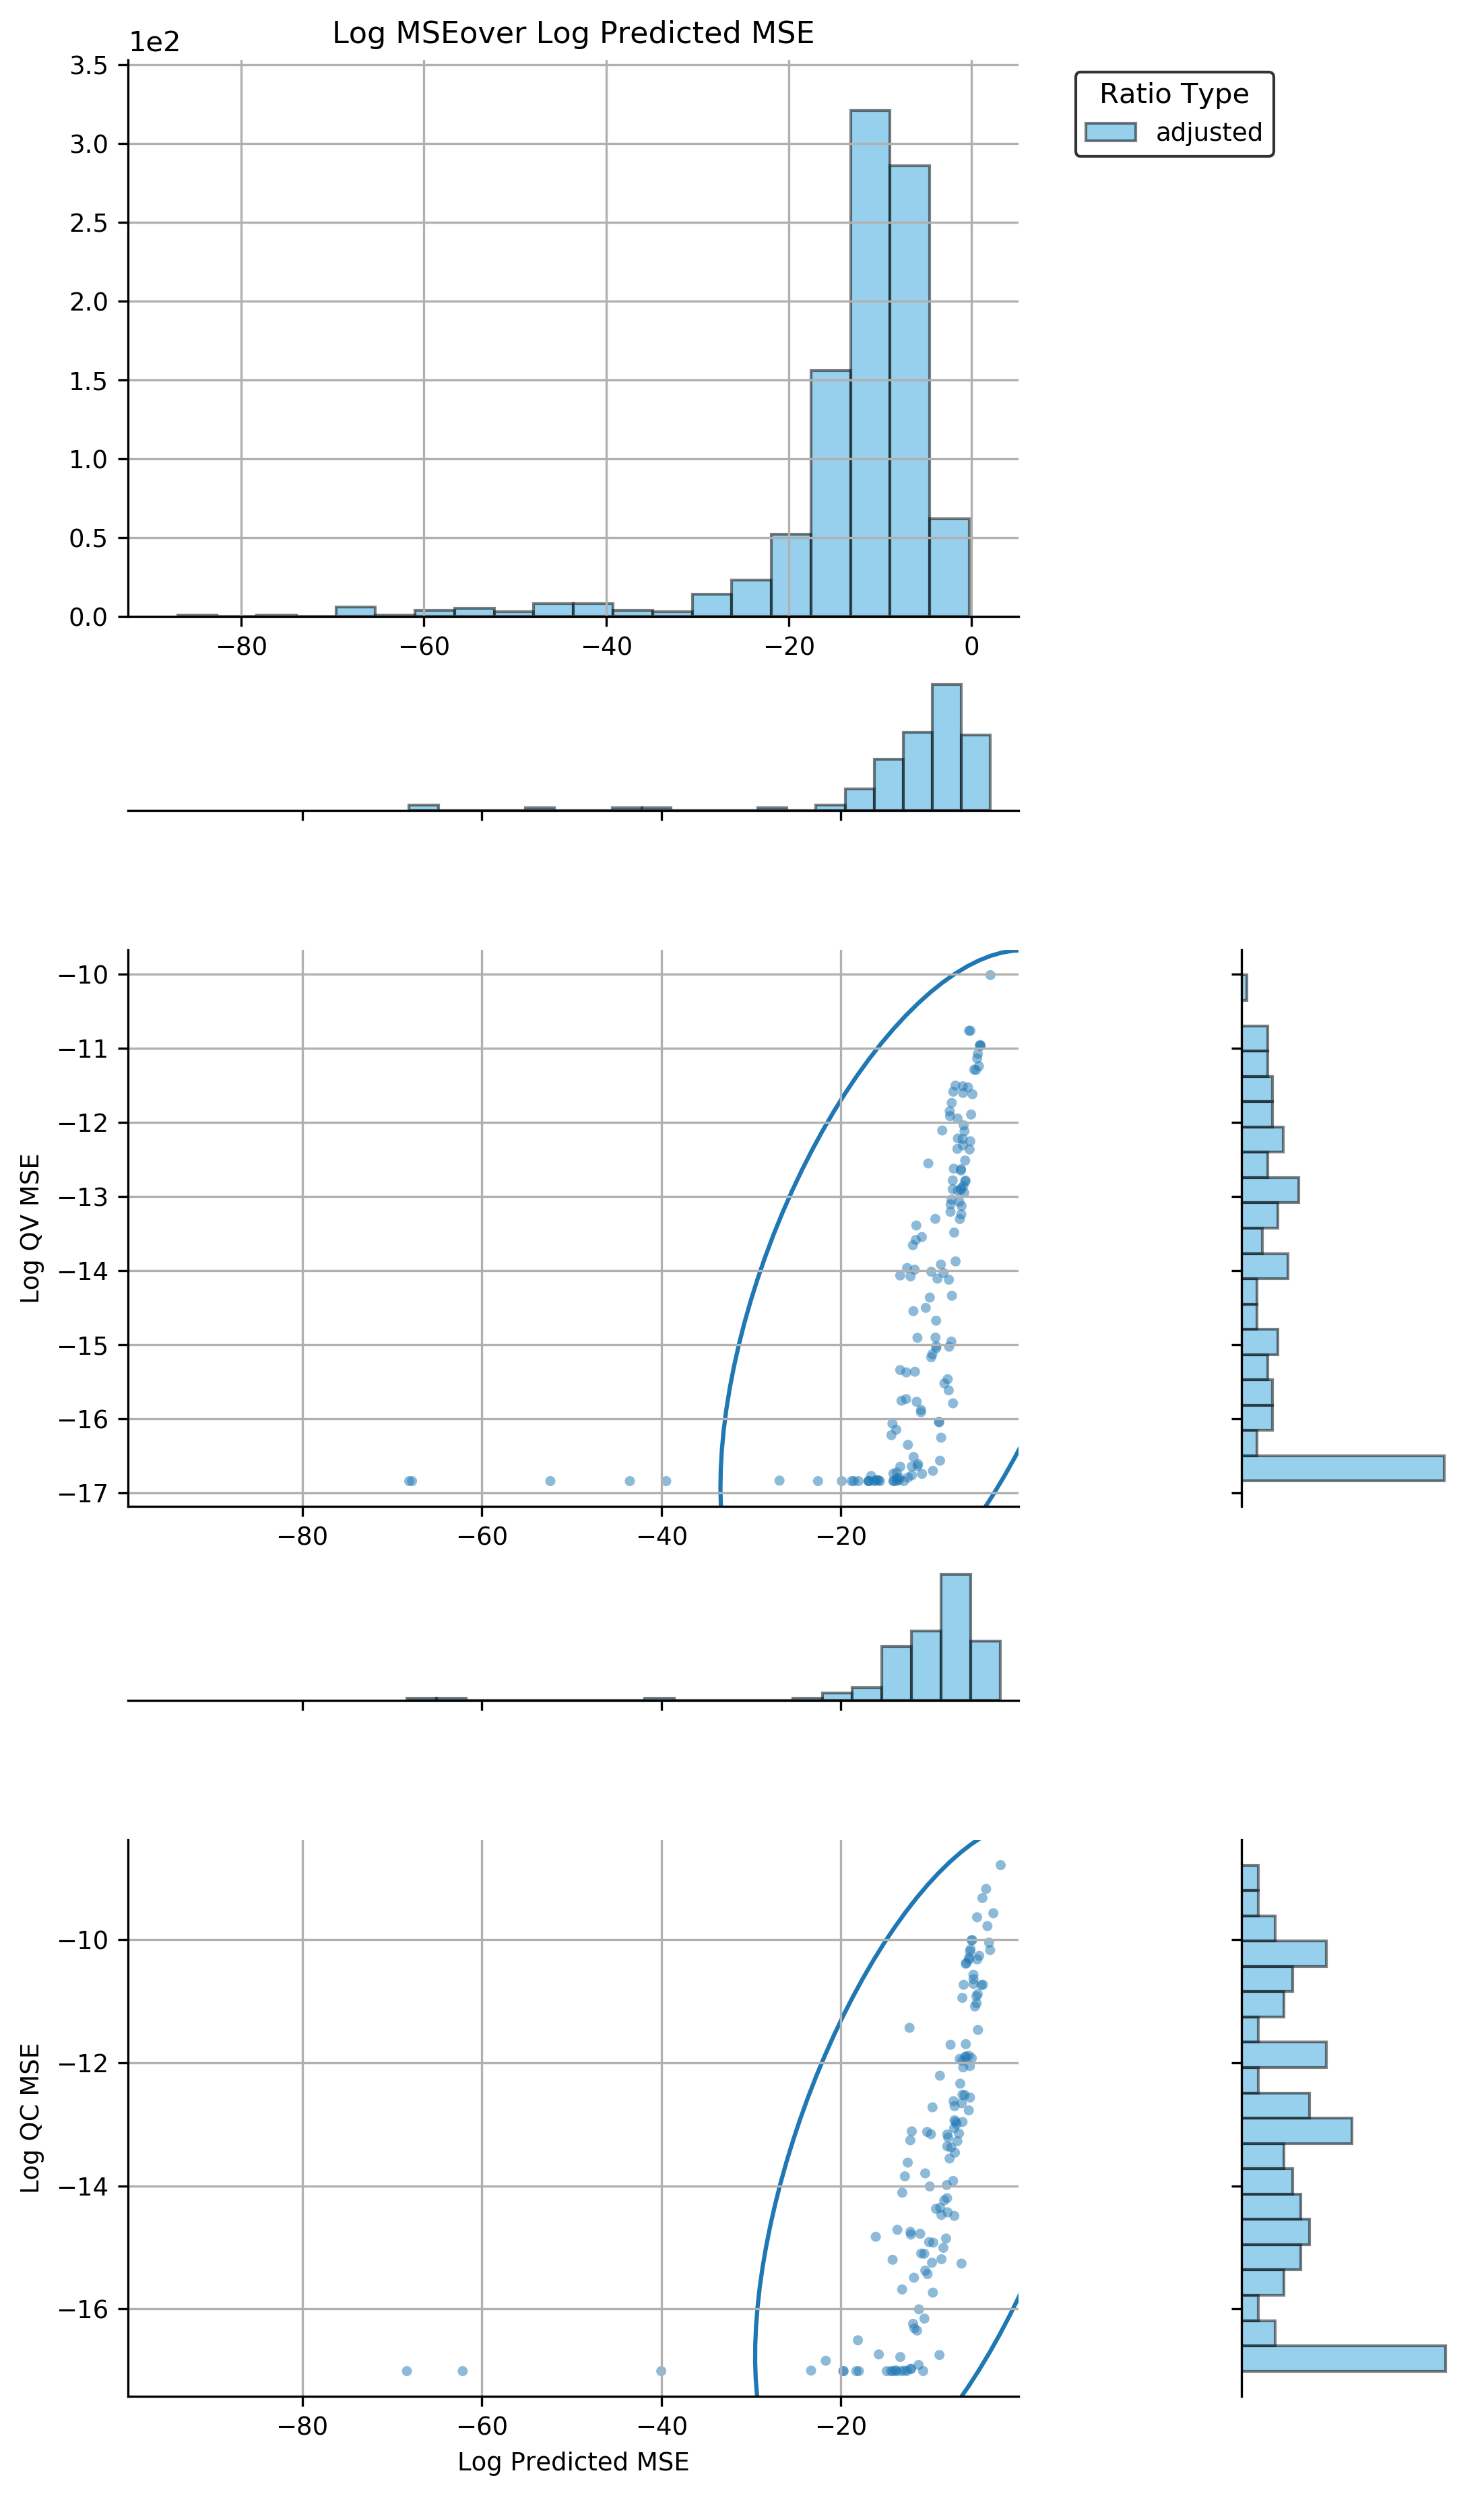

In [7]:
tmp_df = reduced_df.loc[reduced_df["Ratio Type"] == "adjusted"]
tmp_df = tmp_df.loc[tmp_df["Sensitivity"] != 0]
mean_traj.plot_mse(
    out_params=out_params,
    mse_df_=tmp_df,
    in_params=in_params,
    datashade=datashade,
    alpha=alpha,
    formatter_limits=f_limits,
    s=s,
    hist=True,
    confidence=confidence,
    abs_x=True,
    log_x=True,
    log_y=True,
    kind=kind,
    error_key=error_key,
    xlabel="Log Predicted MSE",
    plot_singles=True,
    log_func=np.log10)

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W

-0.5476359516077361
[[ 0.8537578  -0.52067036]
 [ 0.52067036  0.8537578 ]]
slope : 0.6098572254438966 vs 0.609857225443897 and angle 2.593956701982057 vs 2.593956701982057
slope3: -0.6098572254438966 vs -0.609857225443897 and angle 2.593956701982057 vs 2.593956701982057
slope : -0.6098572254438966 vs 0.6098572254438966 and angle 0.5476359516077361 vs 2.593956701982057
slope4: -1.6397280515486716 vs -0.609857225443897 and angle 2.593956701982057 vs -1.0231603751871603


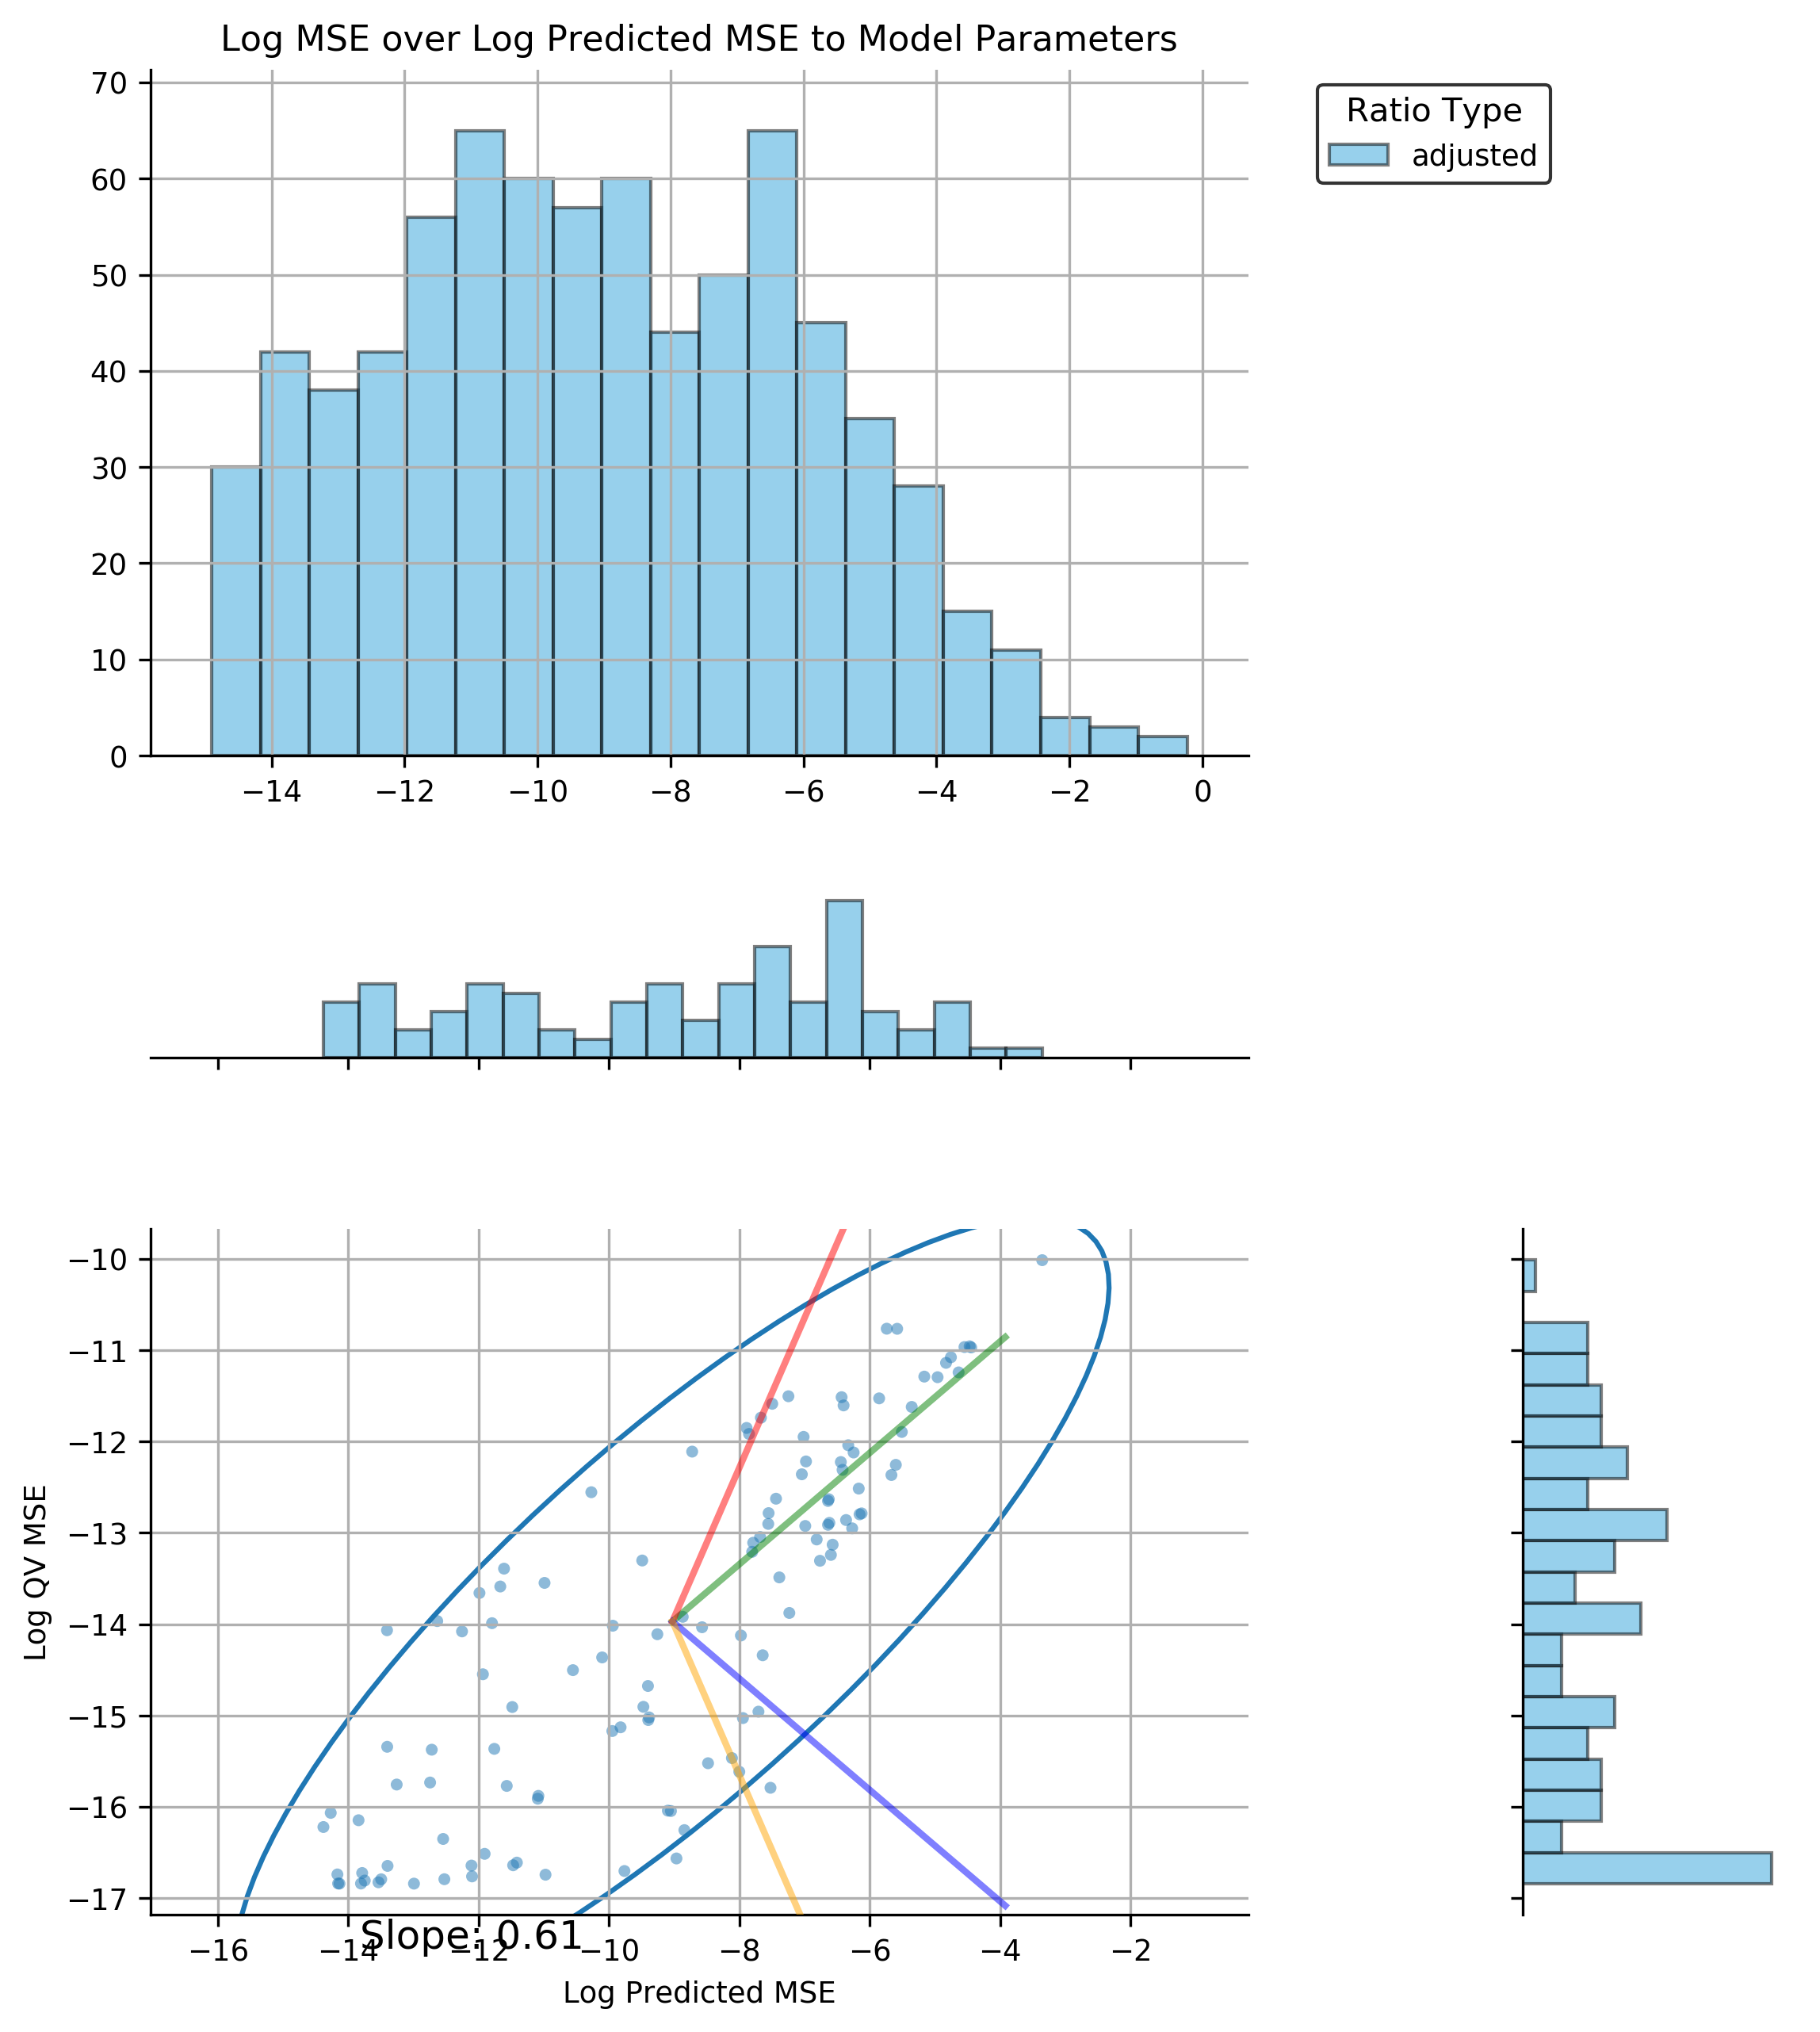

In [8]:
tmp_df = reduced_df.loc[reduced_df["Ratio Type"] == "adjusted"]
tmp_df = tmp_df.loc[tmp_df["Sensitivity"] != 0]
# tmp_df = tmp_df.loc[tmp_df["Sensitivity"] >= 1e-15]
mean_traj.plot_mse(
    out_params=out_params,
    mse_df_=tmp_df,
    in_params=in_params,
    datashade=datashade,
    alpha=alpha,
    formatter_limits=f_limits,
    s=s,
    hist=False,
    confidence=confidence,
    abs_x=True,
    log_x=True,
    log_y=True,
    kind=kind,
    error_key=error_key,
    xlabel="Log Predicted MSE",
    log_func=np.log10)

In [ ]:
tmp_df = reduced_df.loc[reduced_df["Ratio Type"] == "adjusted"]
tmp_df = tmp_df.loc[tmp_df["Sensitivity"] != 0]
tmp_df = tmp_df.loc[tmp_df["Sensitivity"] >= 1e-15]
mean_traj.plot_mse(
    out_params=out_params,
    mse_df_=tmp_df,
    in_params=in_params,
    datashade=datashade,
    alpha=alpha,
    formatter_limits=f_limits,
    s=s,
    hist=True,
    confidence=confidence,
    abs_x=True,
    log_x=True,
    log_y=True,
    kind=kind,
    error_key=error_key,
    xlabel="Log Predicted MSE",
    log_func=np.log10)

### Get the most important parameters

In [ ]:
for out_p in out_params:
    print(out_p)
    df = tmp_df.loc[tmp_df["Output Parameter"] == out_p]
    print(df.nlargest(20, "Sensitivity")[["Perturbed Parameter", error_key, "Sensitivity"]])
    print(df.nlargest(20, error_key)[["Perturbed Parameter", error_key, "Sensitivity"]])
    df.nlargest(20, "Sensitivity")[["Perturbed Parameter", error_key, "Sensitivity"]].to_csv("sens.csv", sep=".", decimal=",")
    df.nlargest(20, error_key)[["Perturbed Parameter", error_key, "Sensitivity"]].to_csv("sim.csv", sep=".", decimal=",")
    break

### Example for fitting a curve

In [10]:
from scipy.optimize import least_squares, curve_fit

tmp_df_qv = tmp_df.loc[tmp_df["Output Parameter"] == "QV"]
tmp_df_qv = tmp_df_qv.loc[tmp_df_qv["Sensitivity"] >= 1e-15]

def model1(sens, coeffs):
    return 10**coeffs[0] * sens**coeffs[1]  #+ (1/sens)**coeffs[2]# + coeffs[2] 

def model2(sens, coeffs):
    return 10**coeffs[0] * sens**coeffs[1] + coeffs[2]

def model3(sens, coeffs):
    return coeffs[0]**sens + coeffs[1]

def model4(sens, coeffs):
    return coeffs[0]**(sens-coeffs[1]) + coeffs[0]

def model5(sens, coeffs):
    return coeffs[0] * np.exp((sens*coeffs[1]))# + coeffs[2] 

def model6(sens, coeffs):
    return coeffs[0]**sens

def model7(sens, coeffs):
    return coeffs[1]*coeffs[0]**sens + coeffs[2]


def residuals(coeffs, y, sens, model):
    return y - model(sens, coeffs)

def residuals_l(coeffs, y, sens, model):
    return np.log(y) - np.log(model(sens, coeffs))

def residuals_oc(coeffs, y, sens, model):
    return y*(np.log(y) - coeffs[0] - coeffs[1]*sens)**2

init_sol = [1, 0.5]
result = least_squares(residuals_l, init_sol, loss="cauchy", args=(tmp_df_qv[error_key], tmp_df_qv["Sensitivity"], model1))
x1 = result.x

init_sol = [1, 0.5, 1e-17]
result = least_squares(residuals, init_sol, loss="cauchy", args=(tmp_df_qv[error_key], tmp_df_qv["Sensitivity"], model2))
x2 = result.x

init_sol = [1, 0.5]
result = least_squares(residuals, init_sol, loss="cauchy", args=(tmp_df_qv[error_key], tmp_df_qv["Sensitivity"], model3))
x3 = result.x

init_sol = [1, 0.5, 1e-17]
result = least_squares(residuals, init_sol, loss="cauchy", args=(tmp_df_qv[error_key], tmp_df_qv["Sensitivity"], model4))
x4 = result.x

init_sol = [1, 0.5]
result = least_squares(residuals_oc, init_sol, loss="cauchy", args=(tmp_df_qv[error_key], tmp_df_qv["Sensitivity"], model5))
x5 = result.x
x5[0] = np.exp(x5[0])

init_sol = [1]
result = least_squares(residuals, init_sol, loss="cauchy", args=(tmp_df_qv[error_key], tmp_df_qv["Sensitivity"], model6))
x6 = result.x

init_sol = [1, 0.5, 1e-17]
result = least_squares(residuals, init_sol, loss="cauchy", args=(tmp_df_qv[error_key], tmp_df_qv["Sensitivity"], model7))
x7 = result.x


[-10.73284412   0.43990597]


In [11]:
from scipy.stats import chi2
import holoviews as hv
import hvplot.pandas

def correl_conf_ell(x, y, by=None, confidence=0.95, color=None,
    **kwargs):
    new_kwargs = kwargs
    if color is not None:
        new_kwargs["color"] = color
    chisq = chi2.ppf(confidence, 2)
    def create_ellipse(x, y, **kwargs):
        cov = np.cov(x, y)
        eigen, eigenv = np.linalg.eig(cov)
        mean_x = np.mean(x)
        mean_y = np.mean(y)
        if eigen[0] > eigen[1]:
            bigger_idx = 0
        else:
            bigger_idx = 1
        rot = np.arctan2(eigenv[bigger_idx][1], eigenv[bigger_idx][0])
        if rot < 0:
            rot += np.pi
        major_scale = chisq * np.sqrt(eigen[bigger_idx])
        minor_scale = chisq * np.sqrt(eigen[(1+bigger_idx)%2])
        if bigger_idx == 1:
            scale = (major_scale, minor_scale)
        else:
            scale = (minor_scale, major_scale)
        scale = (major_scale, minor_scale)
        
        gradients = [v[1] / v[0] for v in eigenv.T]
        print(gradients)
        intercept = mean_y - gradients[0]*mean_x
        
        return (hv.Ellipse(mean_x, mean_y, scale, orientation=-rot).opts(**kwargs) * hv.Curve(
            [ (i, intercept + gradients[0]*i) for i in x ]).opts(color="k") * hv.Text(
                x.iloc[1], (intercept + gradients[0]*x.iloc[1])*1.1, f"Slope: {gradients[0]:.2f}" ) )

    return create_ellipse(x, y, **new_kwargs)
   

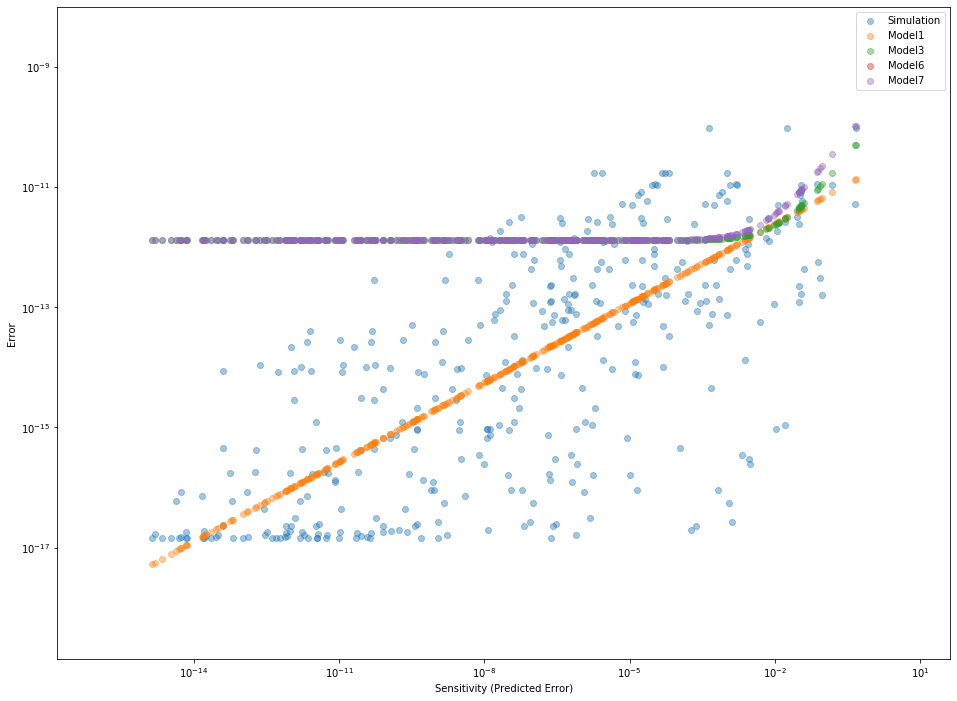

[0.44466227092112653, -2.248897793663673]


:Overlay
   .Scatter.I :Scatter   [Sensitivity]   (MSE)
   .Ellipse.I :Ellipse   [x,y]
   .Curve.I   :Curve   [x]   (y)
   .Text.I    :Text   [x,y]
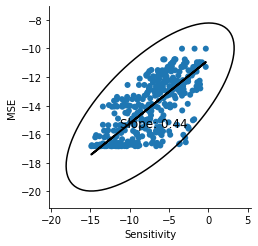

In [12]:
fig, ax = plt.subplots(figsize=(16, 12))
plt.yscale("log")
plt.xscale("log")
plt.scatter(tmp_df_qv["Sensitivity"], tmp_df_qv[error_key], alpha=0.4)
plt.scatter(tmp_df_qv["Sensitivity"], model1(tmp_df_qv["Sensitivity"], x1), alpha=0.4) #
# plt.scatter(tmp_df_qv["Sensitivity"], model2(tmp_df_qv["Sensitivity"], x2), alpha=0.4)
plt.scatter(tmp_df_qv["Sensitivity"], model3(tmp_df_qv["Sensitivity"], x3), alpha=0.4)
# plt.scatter(tmp_df_qv["Sensitivity"], model4(tmp_df_qv["Sensitivity"], x4), alpha=0.4) #
# plt.scatter(tmp_df_qv["Sensitivity"], model5(tmp_df_qv["Sensitivity"], x5), alpha=0.4)
plt.scatter(tmp_df_qv["Sensitivity"], model6(tmp_df_qv["Sensitivity"], x6), alpha=0.4)
plt.scatter(tmp_df_qv["Sensitivity"], model7(tmp_df_qv["Sensitivity"], x7), alpha=0.4)

mi = tmp_df_qv["Sensitivity"].min()
if tmp_df_qv[error_key].min() < mi:
    mi = tmp_df_qv[error_key].min()
ma = tmp_df_qv["Sensitivity"].max()
if tmp_df_qv[error_key].min() > ma:
    ma = tmp_df_qv[error_key].max()
mi = mi/10
ma = ma*10
plt.xlabel('Sensitivity (Predicted Error)')
plt.ylabel('Error')
plt.legend(['Simulation', 
            'Model1', 
#             'Model2', 
            'Model3', 
#             'Model4', 
#             'Model5', 
            'Model6', 
            'Model7'
           ])
# plt.xlim((mi,ma))
# plt.ylim((mi,ma))
s = 54
plt.show()
tmp_df_qv_l = tmp_df_qv.copy()
tmp_df_qv_l["Sensitivity"] = np.log10(tmp_df_qv_l["Sensitivity"])
tmp_df_qv_l[error_key] = np.log10(tmp_df_qv_l[error_key])
(tmp_df_qv_l.hvplot.scatter(
    x="Sensitivity",
    y=error_key) * correl_conf_ell(tmp_df_qv_l["Sensitivity"], tmp_df_qv_l[error_key])).opts(frame_width=16*s, frame_height=12*s)